# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [40]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [14]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

## Download Model

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)


In [24]:
for file in tar_file.getmembers():
    print(file.name)
    file_name = os.path.basename(file.name)
    print(file_name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())



ssd_mobilenet_v1_coco_2017_11_17
ssd_mobilenet_v1_coco_2017_11_17
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.index
model.ckpt.index
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.meta
model.ckpt.meta
ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb
frozen_inference_graph.pb
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.data-00000-of-00001
model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2017_11_17/saved_model
saved_model
ssd_mobilenet_v1_coco_2017_11_17/saved_model/saved_model.pb
saved_model.pb
ssd_mobilenet_v1_coco_2017_11_17/saved_model/variables
variables
ssd_mobilenet_v1_coco_2017_11_17/checkpoint
checkpoint


In [23]:
tar_file.getmembers()

[<TarInfo 'ssd_mobilenet_v1_coco_2017_11_17' at 0x2bda5e3df20>,
 <TarInfo 'ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.index' at 0x2bda5e3db38>,
 <TarInfo 'ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.meta' at 0x2bda5e3dc00>,
 <TarInfo 'ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb' at 0x2bda6084048>,
 <TarInfo 'ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.data-00000-of-00001' at 0x2bda6084110>,
 <TarInfo 'ssd_mobilenet_v1_coco_2017_11_17/saved_model' at 0x2bda60841d8>,
 <TarInfo 'ssd_mobilenet_v1_coco_2017_11_17/saved_model/saved_model.pb' at 0x2bda60842a0>,
 <TarInfo 'ssd_mobilenet_v1_coco_2017_11_17/saved_model/variables' at 0x2bda6084368>,
 <TarInfo 'ssd_mobilenet_v1_coco_2017_11_17/checkpoint' at 0x2bda6084430>]

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [26]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [34]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [10]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

[ 1  5  1 40 40  1  5 38  1 40 40  1  1  1  1  5  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  5  9  1 84  9  1  1  1 16  1  1  1  1  1
  1  5  1  9  1  1  1  1  5  1  1  1  1  1  1  1  1  1 84  1  1  1  9  1
 42  1  1  1  9  1  9  1  1  9  1  1  1 84  1  1  1  1  1 72  1  1  1  1
  1  1  1 18] [0.96361554 0.708724   0.67715347 0.15763783 0.11580575 0.07715172
 0.06975049 0.06439343 0.05559754 0.05385637 0.04857725 0.0469543
 0.04054251 0.03928563 0.03825903 0.03745031 0.03721765 0.03702992
 0.03686851 0.03639522 0.03607059 0.03509125 0.03499931 0.03361532
 0.03321171 0.03305897 0.03278014 0.03271642 0.03234133 0.031683
 0.03146133 0.03127667 0.03060466 0.03049555 0.03016052 0.02960774
 0.02955788 0.02945635 0.02852571 0.02832559 0.02828613 0.02816662
 0.02814418 0.0279991  0.02767745 0.02763781 0.02760637 0.02734405
 0.0273059  0.02721864 0.02623239 0.02619839 0.02618361 0.02597019
 0.0259597  0.02590033 0.02573341 0.02558488 0.02540237 0.02539349
 0.02517298 0.02490631 0.02

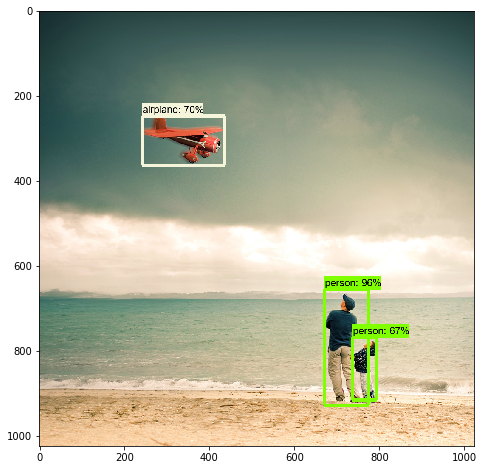

In [39]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  print(output_dict['detection_classes'], output_dict['detection_scores'])
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  break

In [36]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [41]:
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=train.record

  # Create test data:
  python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=test.record
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
import sys
sys.path.append("..")
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

In [42]:
flags = tf.app.flags

In [ ]:
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')

In [43]:
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
flags.DEFINE_string('image_dir', '', 'Path to images')

In [46]:
FLAGS = flags.FLAGS

In [48]:
# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'signature':
        return 1
    elif row_label == 'others':
	    return 2
    else:
        None


In [49]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [51]:
def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [54]:
examples = pd.read_csv('./images/train_labels.csv')

In [56]:
examples.head(
)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,07653e58-24d1-4b3f-9b4a-76057efe5c09-1,1700,2200,signature,192,1188,738,1320
1,07653e58-24d1-4b3f-9b4a-76057efe5c09-1,1700,2200,signature,800,1220,1243,1322
2,07653e58-24d1-4b3f-9b4a-76057efe5c09-1,1700,2200,signature,275,1584,689,1674
3,07653e58-24d1-4b3f-9b4a-76057efe5c09-1,1700,2200,others,924,1440,1153,1540
4,07653e58-24d1-4b3f-9b4a-76057efe5c09-1,1700,2200,signature,689,2018,789,2112


In [57]:
grouped = split(examples, 'filename')

In [66]:
def create_tf_example(group, path):
    with tf.gfile.GFile(path + '/' + group.filename + '.jpg', 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [63]:
os.path.join('a', 'b')

'a\\b'

In [67]:
path = 'images/train'
for group in grouped:
    print(group)
    print(os.path.join(path, '{}'.format(group.filename)))
    tf_example = create_tf_example(group, path)
    break

data(filename='07653e58-24d1-4b3f-9b4a-76057efe5c09-1', object=                                 filename  width  height      class  xmin  \
0  07653e58-24d1-4b3f-9b4a-76057efe5c09-1   1700    2200  signature   192   
1  07653e58-24d1-4b3f-9b4a-76057efe5c09-1   1700    2200  signature   800   
2  07653e58-24d1-4b3f-9b4a-76057efe5c09-1   1700    2200  signature   275   
3  07653e58-24d1-4b3f-9b4a-76057efe5c09-1   1700    2200     others   924   
4  07653e58-24d1-4b3f-9b4a-76057efe5c09-1   1700    2200  signature   689   
5  07653e58-24d1-4b3f-9b4a-76057efe5c09-1   1700    2200  signature   918   

   ymin  xmax  ymax  
0  1188   738  1320  
1  1220  1243  1322  
2  1584   689  1674  
3  1440  1153  1540  
4  2018   789  2112  
5  2032  1051  2106  )
images/train\07653e58-24d1-4b3f-9b4a-76057efe5c09-1


In [53]:
def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(FLAGS.image_dir)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


if __name__ == '__main__':
    tf.app.run()


NotFoundError: Failed to create a NewWriteableFile:  : The system cannot find the path specified.
; No such process

In [68]:
import tarfile

In [69]:
fname = './faster_rcnn_inception_v2_coco_2018_01_28.tar.gz'
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()